In [1]:

import pandas as pd
import numpy as np

In [2]:
from shapely.geometry import Point, Polygon

In [28]:
import shapely.speedups
shapely.speedups.enable()

In [3]:
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

In [5]:
import datetime as dt

In [6]:
edges =gpd.read_file("/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/nodes_links_Chattanooga/Chatt_nodes_elevation.shp")

In [7]:
nodes= gpd.read_file("/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/nodes_links_Chattanooga/Chatt_nodes_xy.shp")

In [8]:
df_gps=gpd.read_file("/Users/kjeong/1_Work/1_3_RMobility/Code/MapMatched/Best_point.shp")

In [9]:
df_gps_CN=pd.DataFrame(df_gps.drop(columns=["Unnamed_ 0",'Unnamed__1','geometry']))

In [10]:
df_gps_CN["Net_Id"] = df_gps_CN.Net_Id.astype(str)

In [11]:
df_gps_CN["flag"]=df_gps_CN.Net_Id.apply(lambda x: x.__contains__(":"))

In [12]:
df_gps_CN=df_gps_CN[df_gps_CN.flag==False].reset_index(drop=True)

In [13]:
df_gps_CN=df_gps_CN.sort_values(by=['VehicleId','Timestamp'])
df_gps_CN=df_gps_CN.drop_duplicates(subset=['VehicleId','Lat','Lon','Timestamp']).reset_index(drop=True)


In [14]:
df_gps_CN_clean=pd.DataFrame(columns=['VehicleId','Lat','Lon','Timestamp', 'Net_Id'])
veh_i_1=0
Lat_i_1=0
Lon_i_1=0
for i in range(0,df_gps_CN.shape[0]):
    if (veh_i_1 != df_gps_CN.VehicleId[i]):
        df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                ,'Lat':df_gps_CN.Lat[i]
                                                ,'Lon':df_gps_CN.Lon[i]
                                                ,'Timestamp':df_gps_CN.Timestamp[i]
                                                , 'Net_Id':df_gps_CN.Net_Id[i] },ignore_index=True)
        veh_i_1=df_gps_CN.VehicleId[i]
        Lat_i_1=df_gps_CN.Lat[i]
        Lon_i_1=df_gps_CN.Lon[i]
    else:    
        if (round(Lat_i_1,2) != round(df_gps_CN.Lat[i],2)) or (round(Lon_i_1,2) != round(df_gps_CN.Lon[i],2)):
            df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                    ,'Lat':df_gps_CN.Lat[i]
                                                    ,'Lon':df_gps_CN.Lon[i]
                                                    ,'Timestamp':df_gps_CN.Timestamp[i]
                                                    , 'Net_Id':df_gps_CN.Net_Id[i]}, ignore_index=True)
            veh_i_1=df_gps_CN.VehicleId[i]
            Lat_i_1=df_gps_CN.Lat[i]
            Lon_i_1=df_gps_CN.Lon[i]
df_ping_by_veh=df_gps_CN_clean.groupby(['VehicleId']).agg('count').reset_index()
df_ping_by_veh_over5 = df_ping_by_veh[df_ping_by_veh.Lat >5]
temp=df_gps_CN_clean[df_gps_CN_clean.VehicleId.isin(df_ping_by_veh_over5.VehicleId)].reset_index()

In [15]:
df_gps_CN_clean["Timestamp"]=pd.to_datetime(df_gps_CN_clean["Timestamp"])

In [16]:
df_gps_CN_clean["Date"]=df_gps_CN_clean["Timestamp"].dt.date

In [17]:
df_gps_CN_clean.head(10)

,VehicleId,Lat,Lon,Timestamp,Net_Id,Date
0,2,34.983780,-85.408417,2021-05-05 16:02:03,15698_0,2021-05-05
1,2,34.939472,-85.165253,2021-05-05 16:55:19,-33294_0,2021-05-05
2,4,34.978790,-85.412933,2021-03-18 22:05:26,18303_0,2021-03-18
3,4,35.011353,-85.245148,2021-03-19 11:03:48,-16088_0,2021-03-19
4,4,35.019871,-85.266663,2021-03-30 16:11:07,-16196_0,2021-03-30
5,4,34.993149,-85.398865,2021-04-09 16:09:54,17524_0,2021-04-09
6,4,35.021526,-85.380524,2021-04-15 22:09:19,15919_1,2021-04-15
7,4,34.901566,-85.086670,2021-04-20 22:00:48,33599_0,2021-04-20
8,4,34.983673,-85.408508,2021-05-13 12:04:05,15698_0,2021-05-13
9,4,35.060612,-85.129578,2021-05-13 13:00:17,296_1,2021-05-13


In [18]:
df_vf_forSP=pd.DataFrame()
for veh_id in df_gps_CN_clean.VehicleId.unique():
    df_vh = df_gps_CN_clean[df_gps_CN_clean.VehicleId == veh_id]
    for date in df_vh.Date.unique():
        df_vh_date= df_vh[df_vh.Date == date].reset_index(drop=True)
        if df_vh_date.shape[0] >=2:
            df_vh_date['st_node']=0
            df_vh_date['ed_node']=0
            for i in range(0,df_vh_date.shape[0]):
                txt=df_vh_date.Net_Id[i].split("_")
                edge=int(txt[0])
                if edge <0:
                    edge = edge *-1
                    df_vh_date['st_node'][i] = edges[edges['ID']==edge].OBJECT_EN.values[0]
                    df_vh_date['ed_node'][i] = edges[edges['ID']==edge].OBJECT_ST.values[0]
                else:
                    df_vh_date['st_node'][i] = edges[edges['ID']==edge].OBJECT_ST.values[0]
                    df_vh_date['ed_node'][i] = edges[edges['ID']==edge].OBJECT_EN.values[0]
            
            df_vf_forSP = pd.concat([df_vf_forSP, df_vh_date], ignore_index=True)        


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_72833/2759920021.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vh_date['st_node'][i] = edges[edges['ID']==edge].OBJECT_ST.values[0]
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_72833/2759920021.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vh_date['ed_node'][i] = edges[edges['ID']==edge].OBJECT_EN.values[0]
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_72833/2759920021.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

In [19]:
G =nx.DiGraph()

In [20]:
for n_id in nodes['OBJECTID'].unique():
    G.add_node(n_id)

In [21]:
for i in range(0, edges.shape[0]):
    if edges.AB_LinkDTR[i] == "F":
        G.add_edge(edges.OBJECT_ST[i],edges.OBJECT_EN[i], length=edges.Length[i])
    if edges.BA_LinkDTR[i] == "T":
        G.add_edge(edges.OBJECT_EN[i], edges.OBJECT_ST[i],length=edges.Length[i])

In [22]:
#print(nx.shortest_path(G, source=15527, target=8840))

In [23]:
df_vf_forSP['Short_path']='[]'  

In [24]:
#for i in range(1,5):
for i in range(1,df_vf_forSP.shape[0]):
    if (df_vf_forSP.VehicleId[i-1] == df_vf_forSP.VehicleId[i]) and (df_vf_forSP.Date[i-1] == df_vf_forSP.Date[i]):
        s=df_vf_forSP.ed_node[i-1]
        t=df_vf_forSP.st_node[i]
        try:
            df_vf_forSP.Short_path[i-1]= nx.shortest_path(G, source=s, target=t)
        except:
            df_vf_forSP.Short_path[i-1] ="no path"
        




/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_72833/1893103270.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vf_forSP.Short_path[i-1]= nx.shortest_path(G, source=s, target=t)
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_72833/1893103270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vf_forSP.Short_path[i-1] ="no path"


In [38]:
df_vf_forSP.head()

,VehicleId,Lat,Lon,Timestamp,Net_Id,Date,st_node,ed_node,Short_path
0,2,34.983780,-85.408417,2021-05-05 16:02:03,15698_0,2021-05-05,3947,3937,"[3937, 3938, 3940, 2745, 2746, 6488, 6603, 644..."
1,2,34.939472,-85.165253,2021-05-05 16:55:19,-33294_0,2021-05-05,43602,43601,[]
2,4,34.983673,-85.408508,2021-05-13 12:04:05,15698_0,2021-05-13,3947,3937,"[3937, 3938, 3940, 2745, 2746, 6488, 6603, 644..."
3,4,35.060612,-85.129578,2021-05-13 13:00:17,296_1,2021-05-13,48004,48008,"[48008, 48006, 57469, 57443, 57444, 57535, 574..."
4,4,35.028412,-85.360870,2021-05-13 23:01:44,-16114_0,2021-05-13,6410,6409,[]


In [30]:
gdf_taz =gpd.read_file("/Users/kjeong/1_Work/1_3_RMobility/INRIX/Clean_TAZ/Clean_TAZ.shp")

In [100]:
df_vf_path=pd.DataFrame(columns = ['VehicleId',
                                      'Date',
                                      'Orig',
                                      'Dest',
                                      'Path'])
#for veh_id in [2, 4, 5,]:
for veh_id in df_vf_forSP.VehicleId.unique():
    df_vh = df_vf_forSP[df_vf_forSP.VehicleId == veh_id]
    for date in df_vh.Date.unique():
        df_vh_date= df_vh[df_vh.Date == date].reset_index(drop=True)
        p_st=Point(df_vh_date.Lon.iloc[0],df_vh_date.Lat.iloc[0])
        p_ed=Point(df_vh_date.Lon.iloc[-1],df_vh_date.Lat.iloc[-1])
        try:
            orig=gdf_taz[gdf_taz.geometry.contains(p_st)].TAZID.values[0]
        except:
            orig=float("NaN")
        try:
            dest=gdf_taz[gdf_taz.geometry.contains(p_ed)].TAZID.values[0]
        except:
            dest=float("NaN")
        path=[]
        for i in range(0,df_vh_date.shape[0]):
            if (df_vh_date.Short_path[0] != '[]') and (df_vh_date.Short_path[0] != 'no path'):
                no_path = False
                if i==0:
                    path=[df_vh_date.st_node[0]]+df_vh_date.Short_path[i]
                else:
                    if (df_vh_date.Short_path[i] == '[]') or (df_vh_date.Short_path[i] == 'no path'):
                        path= path+[df_vh_date.ed_node[i]]
                    else:
                        path= path+df_vh_date.Short_path[i]
            else:
                no_path = True
        if no_path == False: 
            df_vf_path=df_vf_path.append({'VehicleId': veh_id,
                                              'Date': date,
                                              'Orig': orig,
                                              'Dest': dest,
                                              'Path': path},ignore_index=True)

In [103]:
df_vf_path.head(20)

,VehicleId,Date,Orig,Dest,Path
0,2,2021-05-05,715,65,"[3947, 3937, 3938, 3940, 2745, 2746, 6488, 660..."
1,4,2021-05-13,715,380,"[3947, 3937, 3938, 3940, 2745, 2746, 6488, 660..."
2,5,2021-02-27,796,150,"[595, 44353, 44388, 44397, 44399, 44391, 44392..."
3,5,2021-05-25,96,34,"[41750, 41749, 59031, 58904, 58905, 59009, 590..."
4,5,2021-05-27,150,796,"[3938, 3940, 2745, 2746, 6488, 6603, 6447, 644..."
5,5,2021-06-02,76,849,"[41841, 41842, 42742, 43093, 43094, 41823, 418..."
6,5,2021-06-17,150,482,"[2745, 2746, 6488, 6603, 6447, 6448, 6743, 640..."
7,24,2021-01-18,380,881,"[6406, 6408, 7015, 2749, 2750, 20640, 20751, 2..."
8,26,2021-03-25,150,96,"[3947, 3937, 3938, 3940, 2745, 2746, 6488, 660..."
9,28,2021-04-22,96,150,"[41750, 41749, 59031, 58904, 58905, 59009, 590..."


In [102]:
df_vf_path.dropna(subset = ["Orig"], inplace=True)
df_vf_path.dropna(subset = ["Dest"], inplace=True)

In [104]:
df_path_OD=df_vf_path.groupby(['Orig','Dest']).size().reset_index().rename(columns={0:'count'})

In [105]:
df_path_OD=df_path_OD.sort_values(by=['count'],ascending=False)

In [114]:
df_path_OD.dtypes

Orig     int64
Dest     int64
count    int64
dtype: object

In [126]:
df_path_OD_over_2=df_path_OD[df_path_OD['count']>1].reset_index()

In [119]:
df_path_OD.shape

(4624, 3)

In [182]:
df_path_OD_over_2.shape

(1311, 4)

In [183]:
df_path_dist=pd.DataFrame()
for t in range(0,df_path_OD_over_2.shape[0]):
    df = df_vf_path[(df_vf_path.Orig== df_path_OD_over_2.Orig[t]) & (df_vf_path.Dest==df_path_OD_over_2.Dest[t])].reset_index(drop=True)
    temp= pd.DataFrame(columns=['Orig','Dest','Path_id','Path_seq','count'])
    temp= temp.append({'Orig':df_path_OD_over_2.Orig[t],
                                      'Dest': df_path_OD_over_2.Dest[t],
                                      'Path_id': 1,       
                                      'Path_seq': df.Path[0],
                                      'count': 1},ignore_index=True)
    for i in range(1,df.shape[0]):
        path_unique_flag=False
        for j in range(0,temp.shape[0]):
            difference = set(df.Path[i]).symmetric_difference(set(temp.Path_seq[j]))
            list_difference = list(difference)
            pct_diff=len(list_difference)/(len(df.Path[i])+len(temp.Path_seq[j]))*100
            if pct_diff <= 30:
                path_unique_flag=False
                temp['count'][j]=temp['count'][j]+1
            else: path_unique_flag=True
        if path_unique_flag==True:
            temp= temp.append({'Orig':df_path_OD_over_2.Orig[t],
                                  'Dest': df_path_OD_over_2.Dest[t],
                                  'Path_id': temp.Path_id.iloc[-1]+1,       
                                  'Path_seq': df.Path[i],
                                  'count': 1},ignore_index=True)
    df_path_dist = pd.concat([df_path_dist, temp], ignore_index=True)  

In [184]:
df_path_dist

,Orig,Dest,Path_id,Path_seq,count
0,715,715,1,"[6453, 6593, 6453, 6591, 6527, 6528, 6563, 648...",2
1,715,715,2,"[3980, 3982, 2745, 2746, 6486, 6530, 6531, 653...",2
2,715,715,3,"[3947, 3937, 3938, 3940, 2745, 2746, 6486, 653...",1
3,715,715,4,"[3980, 3982, 2745, 2746, 6486, 6559, 6493, 656...",3
4,715,715,5,"[3947, 3937, 3938, 3940, 3980, 3982]",2
...,...,...,...,...,...
2650,719,43,1,"[46120, 41841, 41842, 42742, 43095, 43096, 430...",1
2651,719,43,2,"[46095, 46096, 46095, 46542, 46111, 46110, 461...",1
2652,17,427,1,"[19305, 19304, 19303, 19546, 19545, 19540, 184...",1
2653,17,427,2,"[19538, 19549, 19293, 19295, 19296, 19291, 192...",1


In [185]:
df_path_dist.to_csv('dist_result.csv')

In [174]:
df_path_dist=pd.DataFrame()

In [175]:
df = df_vf_path[(df_vf_path.Orig== df_path_OD_over_2.Orig[t]) & (df_vf_path.Dest==df_path_OD_over_2.Dest[t])].reset_index(drop=True)
temp= pd.DataFrame(columns=['Orig','Dest','Path_id','Path_seq','count'])
temp= temp.append({'Orig':df_path_OD_over_2.Orig[t],
                                  'Dest': df_path_OD_over_2.Dest[t],
                                  'Path_id': 1,       
                                  'Path_seq': df.Path[0],
                                  'count': 1},ignore_index=True)
for i in range(1,df.shape[0]):
    path_unique_flag=False
    for j in range(0,temp.shape[0]):
        difference = set(df.Path[i]).symmetric_difference(set(temp.Path_seq[j]))
        list_difference = list(difference)
        pct_diff=len(list_difference)/(len(df.Path[i])+len(temp.Path_seq[j]))*100
        if pct_diff <= 30:
            path_unique_flag=False
            temp['count'][j]=temp['count'][j]+1
        else: path_unique_flag=True
    if path_unique_flag==True:
        temp= temp.append({'Orig':df_path_OD_over_2.Orig[t],
                              'Dest': df_path_OD_over_2.Dest[t],
                              'Path_id': temp.Path_id.iloc[-1]+1,       
                              'Path_seq': df.Path[i],
                              'count': 1},ignore_index=True)
df_path_dist = pd.concat([df_path_dist, temp], ignore_index=True) 

In [179]:
df_path_dist

,Orig,Dest,Path_id,Path_seq,count
0,715,715,1,"[6453, 6593, 6453, 6591, 6527, 6528, 6563, 648...",2
1,715,715,2,"[3980, 3982, 2745, 2746, 6486, 6530, 6531, 653...",2
2,715,715,3,"[3947, 3937, 3938, 3940, 2745, 2746, 6486, 653...",1
3,715,715,4,"[3980, 3982, 2745, 2746, 6486, 6559, 6493, 656...",3
4,715,715,5,"[3947, 3937, 3938, 3940, 3980, 3982]",2
...,...,...,...,...,...
88,715,715,89,"[6467, 6480, 6467, 6461, 6157, 6460, 6534, 653...",1
89,715,715,90,"[6651, 6653, 6650, 6613, 6614, 6629, 6464, 646...",1
90,715,715,91,"[6467, 6480, 6467, 6461, 6462, 6461]",1
91,715,715,92,"[6467, 6480, 6467, 6463, 6464, 6617, 6628, 676...",2


In [178]:
i

112

In [160]:
df = df_vf_path[(df_vf_path.Orig== df_path_OD_over_2.Orig[t]) & (df_vf_path.Dest==df_path_OD_over_2.Dest[t])].reset_index(drop=True)
temp= pd.DataFrame(columns=['Orig','Dest','Path_id','Path_seq','count'])
temp= temp.append({'Orig':df_path_OD_over_2.Orig[t],
                                  'Dest': df_path_OD_over_2.Dest[t],
                                  'Path_id': 1,       
                                  'Path_seq': df.Path[0],
                                  'count': 1},ignore_index=True)

In [163]:
temp.count[j]

TypeError: 'method' object is not subscriptable

In [158]:
df.Path[0]

[6453,
 6593,
 6453,
 6591,
 6527,
 6528,
 6563,
 6489,
 6488,
 6603,
 6447,
 6448,
 6743,
 6405,
 6406,
 6408,
 7015,
 2749,
 2750,
 20640,
 20751,
 20749,
 19937,
 19938,
 21563,
 21535,
 21536,
 21658,
 21541,
 21542,
 21826,
 21793,
 21794,
 21796,
 21415,
 21416,
 22153,
 21399,
 22161,
 21419,
 21420,
 23297,
 23249,
 23250,
 23383,
 23389,
 23381,
 23382,
 23254,
 23252,
 23245,
 23214,
 23213,
 23195,
 23179,
 21448,
 21447,
 21508,
 21397,
 21959,
 22196,
 22195,
 22080,
 22074,
 22122,
 22114,
 21394,
 21391,
 21798,
 21797,
 21828,
 21550,
 21549,
 21546,
 21543,
 21568,
 2756,
 2755,
 7013,
 7014,
 6412,
 6411,
 6410,
 6409,
 6745,
 6450,
 6449,
 6493,
 6566,
 6486,
 6530,
 6527,
 6591,
 6453,
 6593]

In [130]:
df = df_vf_path[(df_vf_path.Orig== df_path_OD_over_2.Orig[i]) & (df_vf_path.Dest==df_path_OD_over_2.Dest[i])].reset_index()

In [134]:
difference = set(df.Path[0]).symmetric_difference(set(df.Path[1]))
list_difference = list(difference)

In [139]:
len(list_difference)/(len(df.Path[0])+len(df.Path[1]))*100

7.894736842105263

In [132]:
df.Path[0]

[6453,
 6593,
 6453,
 6591,
 6527,
 6528,
 6563,
 6489,
 6488,
 6603,
 6447,
 6448,
 6743,
 6405,
 6406,
 6408,
 7015,
 2749,
 2750,
 20640,
 20751,
 20749,
 19937,
 19938,
 21563,
 21535,
 21536,
 21658,
 21541,
 21542,
 21826,
 21793,
 21794,
 21796,
 21415,
 21416,
 22153,
 21399,
 22161,
 21419,
 21420,
 23297,
 23249,
 23250,
 23383,
 23389,
 23381,
 23382,
 23254,
 23252,
 23245,
 23214,
 23213,
 23195,
 23179,
 21448,
 21447,
 21508,
 21397,
 21959,
 22196,
 22195,
 22080,
 22074,
 22122,
 22114,
 21394,
 21391,
 21798,
 21797,
 21828,
 21550,
 21549,
 21546,
 21543,
 21568,
 2756,
 2755,
 7013,
 7014,
 6412,
 6411,
 6410,
 6409,
 6745,
 6450,
 6449,
 6493,
 6566,
 6486,
 6530,
 6527,
 6591,
 6453,
 6593]

In [133]:
df.Path[1]

[3800,
 3947,
 3937,
 3938,
 3940,
 2745,
 2746,
 6488,
 6603,
 6447,
 6448,
 6743,
 6405,
 6406,
 6408,
 7015,
 2749,
 2750,
 20640,
 20751,
 20749,
 19937,
 19938,
 21563,
 21535,
 21536,
 21658,
 21541,
 21542,
 21826,
 21793,
 21794,
 21796,
 21415,
 21416,
 22153,
 21399,
 22161,
 21419,
 21420,
 23297,
 23249,
 23250,
 23383,
 23389,
 23381,
 23382,
 23386,
 23213,
 23214,
 23224,
 23214,
 23213,
 23195,
 23179,
 21448,
 21447,
 21508,
 21397,
 21959,
 22196,
 22195,
 22080,
 22074,
 22122,
 22114,
 21394,
 21391,
 21798,
 21797,
 21828,
 21550,
 21549,
 21546,
 21543,
 21568,
 2756,
 2755,
 7013,
 7014,
 6412,
 6411,
 6410,
 6409,
 6745,
 6450,
 6449,
 6493,
 6566,
 6486,
 6530,
 6527,
 6591,
 6453,
 6593]

/Users/kjeong/anaconda3/envs/python38/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

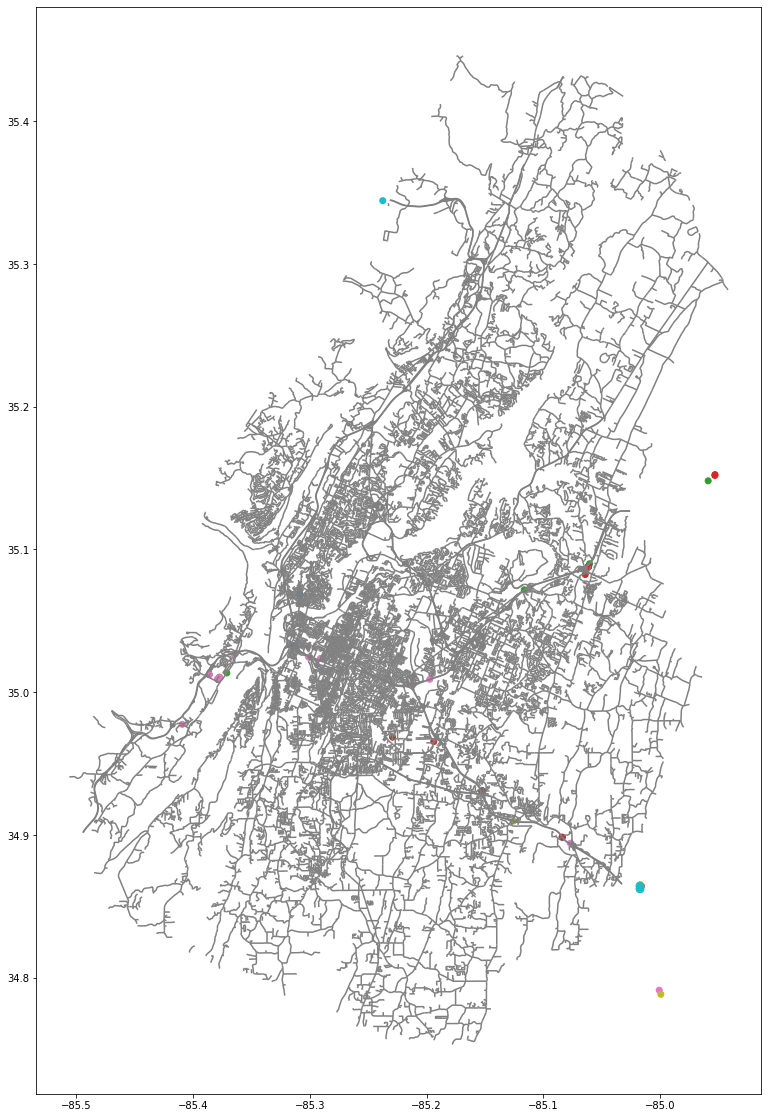

In [8]:
file_dir="/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/fw_data/"
file_nm=file_dir+"gis_datafile3_20210324.csv"
df_gps=pd.read_csv(file_nm)
lon_max=nodes.xcoord.max()
lon_min=nodes.xcoord.min()
lat_max=nodes.ycoord.max()
lat_min=nodes.ycoord.min()
df_gps_CN=df_gps[(df_gps.Lat<=lat_max) & (df_gps.Lat>=lat_min) 
                 & (df_gps.Lon<=lon_max) & (df_gps.Lon>=lon_min)]
df_gps_CN=df_gps_CN.sort_values(by=['VehicleId','Timestamp'])
df_gps_CN=df_gps_CN.drop_duplicates(subset=['VehicleId','Lat','Lon','Timestamp']).reset_index(drop=True)
df_gps_CN_clean=pd.DataFrame(columns=['VehicleId','Lat','Lon','Timestamp'])
veh_i_1=0
Lat_i_1=0
Lon_i_1=0
for i in range(0,df_gps_CN.shape[0]):
    if (veh_i_1 != df_gps_CN.VehicleId[i]):
        df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                ,'Lat':df_gps_CN.Lat[i]
                                                ,'Lon':df_gps_CN.Lon[i]
                                                ,'Timestamp':df_gps_CN.Timestamp[i]},ignore_index=True)
        veh_i_1=df_gps_CN.VehicleId[i]
        Lat_i_1=df_gps_CN.Lat[i]
        Lon_i_1=df_gps_CN.Lon[i]
    else:    
        if (round(Lat_i_1,3) != round(df_gps_CN.Lat[i],3)) or (round(Lon_i_1,3) != round(df_gps_CN.Lon[i],3)):
            df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                    ,'Lat':df_gps_CN.Lat[i]
                                                    ,'Lon':df_gps_CN.Lon[i]
                                                    ,'Timestamp':df_gps_CN.Timestamp[i]}, ignore_index=True)
            veh_i_1=df_gps_CN.VehicleId[i]
            Lat_i_1=df_gps_CN.Lat[i]
            Lon_i_1=df_gps_CN.Lon[i]
df_ping_by_veh=df_gps_CN_clean.groupby(['VehicleId']).agg('count').reset_index()
df_ping_by_veh_over5 = df_ping_by_veh[df_ping_by_veh.Lat >5]
temp=df_gps_CN_clean[df_gps_CN_clean.VehicleId.isin(df_ping_by_veh_over5.VehicleId)].reset_index()
#temp.to_csv(file_dir+"CN"+"gis_datafile3_20210324.csv")

crs ={'init': 'epsg:4019'}
temp_geometry = [Point(xy) for xy in zip(temp.Lon,temp.Lat)]
geo_temp_df=gpd.GeoDataFrame(temp, crs=crs, geometry=temp_geometry)

fig, ax = plt.subplots(figsize = (20,20)) 
edges.plot(ax=ax, color="grey")
geo_temp_df.plot(ax=ax, column='VehicleId')

In [119]:
# from leuvenmapmatching.matcher.distance import DistanceMatcher
# from leuvenmapmatching.map.inmem import InMemMap

# map_con = InMemMap("mymap", graph={
#     "A": ((1, 1), ["B", "C", "X"]),
#     "B": ((1, 3), ["A", "C", "D", "K"]),
#     "C": ((2, 2), ["A", "B", "D", "E", "X", "Y"]),
#     "D": ((2, 4), ["B", "C", "F", "E", "K", "L"]),
#     "E": ((3, 3), ["C", "D", "F", "Y"]),
#     "F": ((3, 5), ["D", "E", "L"]),
#     "X": ((2, 0), ["A", "C", "Y"]),
#     "Y": ((3, 1), ["X", "C", "E"]),
#     "K": ((1, 5), ["B", "D", "L"]),
#     "L": ((2, 6), ["K", "D", "F"])
# }, use_latlon=False)

# path = [(0.8, 0.7), (0.9, 0.7), (1.1, 1.0), (1.2, 1.5), (1.2, 1.6), (1.1, 2.0),
#         (1.1, 2.3), (1.3, 2.9), (1.2, 3.1), (1.5, 3.2), (1.8, 3.5), (2.0, 3.7),
#         (2.3, 3.5), (2.4, 3.2), (2.6, 3.1), (2.9, 3.1), (3.0, 3.2),
#         (3.1, 3.8), (3.0, 4.0), (3.1, 4.3), (3.1, 4.6), (3.0, 4.9)]

# matcher = DistanceMatcher(map_con, max_dist=2, obs_noise=1, min_prob_norm=0.5)
# states, _ = matcher.match(path)
# nodes = matcher.path_pred_onlynodes

# print("States\n------")
# print(states)
# print("Nodes\n------")
# print(nodes)
# print("")
# matcher.print_lattice_stats()

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
Searching closeby nodes with linear search, use an index and set max_dist


States
------
[('X', 'A'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('B', 'D'), ('B', 'D'), ('B', 'D'), ('B', 'D'), ('D', 'E'), ('D', 'E'), ('D', 'E'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F')]
Nodes
------
['X', 'A', 'B', 'D', 'E', 'F']

Stats lattice
-------------
nbr levels               : 22
nbr lattice              : 1002
avg lattice[level]       : 45.54545454545455
min lattice[level]       : 7
max lattice[level]       : 97
avg obs distance         : 0.15514927458475236
last logprob             : -0.5464565099511667
last length              : 22
last norm logprob        : -0.024838932270507576


In [5]:
# from leuvenmapmatching.matcher.distance import DistanceMatcher
# from leuvenmapmatching.map.inmem import InMemMap
# from leuvenmapmatching import visualization as mmviz

# path = [(1, 0), (7.5, 0.65), (10.1, 1.9)]
# mapdb = InMemMap("mymap", graph={
#     "A": ((1, 0.00), ["B"]),
#     "B": ((3, 0.00), ["A", "C"]),
#     "C": ((4, 0.70), ["B", "D"]),
#     "D": ((5, 1.00), ["C", "E"]),
#     "E": ((6, 1.00), ["D", "F"]),
#     "F": ((7, 0.70), ["E", "G"]),
#     "G": ((8, 0.00), ["F", "H"]),
#     "H": ((10, 0.0), ["G", "I"]),
#     "I": ((10, 2.0), ["H"])
# }, use_latlon=False)
# matcher = DistanceMatcher(mapdb, max_dist_init=0.2, obs_noise=1, obs_noise_ne=10,
#                           non_emitting_states=True, only_edges=True)
# states, _ = matcher.match(path)
# nodes = matcher.path_pred_onlynodes

# print("States\n------")
# print(states)
# print("Nodes\n------")
# print(nodes)
# print("")
# matcher.print_lattice_stats()

# mmviz.plot_map(mapdb, matcher=matcher,
#               show_labels=True, show_matching=True,
#               filename="output.png")

Searching closeby nodes with linear search, use an index and set max_dist


States
------
[('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'E'), ('E', 'F'), ('F', 'G'), ('G', 'H'), ('H', 'I')]
Nodes
------
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

Stats lattice
-------------
nbr levels               : 3
nbr lattice              : 40
avg lattice[level]       : 13.333333333333334
min lattice[level]       : 8
max lattice[level]       : 16
avg obs distance         : 0.26790850746762634
last logprob             : -2.373678241605297
last length              : 3
last norm logprob        : -0.791226080535099


(None, None)

In [6]:
# from pathlib import Path
# import requests
# xml_file = Path(".") / "osm.xml"
# url = 'http://overpass-api.de/api/map?bbox=4.694933,50.870047,4.709256000000001,50.879628'
# r = requests.get(url, stream=True)
# with xml_file.open('wb') as ofile:
#     for chunk in r.iter_content(chunk_size=1024):
#         if chunk:
#             ofile.write(chunk)

In [8]:
# import osmread

# map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
# for entity in osmread.parse_file(str(xml_file)):
#     if isinstance(entity, osmread.Way) and 'highway' in entity.tags:
#         for node_a, node_b in zip(entity.nodes, entity.nodes[1:]):
#             map_con.add_edge(node_a, node_b)
#             # Some roads are one-way. We'll add both directions.
#             map_con.add_edge(node_b, node_a)
#     if isinstance(entity, osmread.Node):
#         map_con.add_node(entity.id, (entity.lat, entity.lon))
# map_con.purge()

In [1]:
import geopandas as gpd

In [2]:
edges =gpd.read_file("/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/nodes_links_Chattanooga/Chatt_nodes_elevation.shp")

In [3]:
edges.head()

,OBJECTID,ID,Dir,Length,IDx,AB_LinkDir,BA_LinkDir,AB_LinkDTR,BA_LinkDTR,NAV_ID,...,lon_start,lon_end,lat_start,lat_end,AB_grade_p,BA_grade_p,altitude_f,OBJECT_ST,OBJECT_EN,geometry
0,4,111,1,0.143626,111,124158656F,0,F,0,124158656,...,35.126035,35.127973,-85.294314,-85.293386,3.893685542293776,-3.893685542293776,919,7,8,"LINESTRING (-85.29431 35.12604, -85.29404 35.1..."
1,5,284,1,0.423833,284,772861562F,0,F,0,772861562,...,35.122203,35.127973,-85.295926,-85.293386,5.131262580434414,-5.131262580434414,919,9,8,"LINESTRING (-85.29593 35.12220, -85.29574 35.1..."
2,6,635,-1,0.134487,635,0,124158654T,0,T,124158654,...,35.126332,35.128143,-85.294515,-85.293636,6.468439525122388,-6.468439525122388,919,11,12,"LINESTRING (-85.29451 35.12633, -85.29427 35.1..."
3,7,1101,0,0.089040,1101,87494546F,87494546T,F,T,87494546,...,35.126833,35.128043,-85.284586,-85.284036,-2.093575168391176,2.093575168391176,797,13,14,"LINESTRING (-85.28459 35.12683, -85.28404 35.1..."
4,8,1198,0,0.240757,1198,87494600F,87494600T,F,T,87494600,...,35.125223,35.128603,-85.247546,-85.246476,-3.097083836531948,3.097083836531948,745,15,16,"LINESTRING (-85.24755 35.12522, -85.24648 35.1..."


In [5]:
nodes.head()

,OBJECTID,ID,Elevation,BYPS,TagID,Centroid,SIGNAL,TAZID,Links,Access,Control_Im,PNR_NODE,PNR_COST,PNR_SHED,Urban,Multilane,xcoord,ycoord,geometry
0,1,1003,0.0,None,1003,1,0,1003,1,1,0,0,0.0,0.0,1,1,-84.93425,35.33194,POINT (-84.93425 35.33194)
1,2,11058,0.0,None,11058,0,0,0,2,1,0,0,0.0,0.0,0,1,-84.95884,35.30159,POINT (-84.95884 35.30159)
2,3,3865,0.0,None,3865,0,0,0,4,1,2,0,0.0,0.0,0,1,-84.94635,35.28764,POINT (-84.94635 35.28764)
3,4,1037,0.0,None,1037,1,0,1037,1,1,0,0,0.0,0.0,1,1,-84.90171,35.31839,POINT (-84.90171 35.31839)
4,5,11161,0.0,None,11161,0,0,0,2,1,0,0,0.0,0.0,0,1,-84.94202,35.28189,POINT (-84.94202 35.28189)


In [4]:
lon_max=nodes.xcoord.max()
lon_min=nodes.xcoord.min()
lat_max=nodes.ycoord.max()
lat_min=nodes.ycoord.min()

In [5]:
print (lon_max, lon_min, lat_max, lat_min)

-84.90171 -85.50579 35.45565 34.75295


In [41]:
# import osmnx
# graph = ox.graph_from_place('Leuven, Belgium', network_type='drive')
# graph_proj = ox.project_graph(graph)

In [126]:
# map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
import numpy as np

In [8]:
import pandas as pd

In [129]:
# #x: lon y: lat
# for i in range (0,nodes.shape[0]):
#     a=nodes.OBJECTID[i].item()
#     b=nodes.xcoord[i].item()
#     c=nodes.ycoord[i].item()
#     map_con.add_node(a, (c,b))    
#     # map_con.add_node(nid, (row['lat'], row['lon']))

In [130]:
# for i in range (0,edges.shape[0]):
#     a=edges.OBJECT_ST[i].item()
#     b=edges.OBJECT_EN[i].item()
#     if edges.AB_LinkDTR[i] == "F":
#         map_con.add_edge(a, b)
#     if edges.BA_LinkDTR[i] == "T":
#         map_con.add_edge(b, a)

In [210]:
# map_con.purge()

1. node id, lat, long
2. node id1, node id2 

In [47]:
file_dir="/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/fw_data/"
file_nm=file_dir+"gis_datafile3_20210505.csv"
df_gps=pd.read_csv(file_nm)

In [48]:
df_gps.head()

,Unnamed: 0,VehicleId,Lat,Lon,Timestamp
0,0,1102,38.189697,-85.737427,2021-05-04 17:06:22
1,1,959,38.211788,-85.566895,2021-05-04 21:49:49
2,2,9012,39.610184,-76.993469,2021-04-14 23:53:16
3,3,11125,38.211819,-85.566925,2021-04-12 15:35:21.817000000
4,4,10729,38.211765,-85.567047,2021-05-05 04:32:04


In [54]:
df_gps.shape

(749975, 5)

In [69]:
df_gps_CN=df_gps[(df_gps.Lat<=lat_max) & (df_gps.Lat>=lat_min) 
                 & (df_gps.Lon<=lon_max) & (df_gps.Lon>=lon_min)]

In [70]:
df_gps_CN.shape

(9752, 5)

In [71]:
df_gps_CN=df_gps_CN.sort_values(by=['VehicleId','Timestamp'])

In [78]:
df_gps_CN.head(10)

,Unnamed: 0,VehicleId,Lat,Lon,Timestamp
0,18140,2,34.983780,-85.408417,2021-05-05 16:02:03
1,19734,2,34.939472,-85.165253,2021-05-05 16:55:19
2,2222,104,35.136162,-84.908569,2021-05-05 06:01:12
3,18900,104,35.136162,-84.908569,2021-05-05 07:01:41
4,18695,104,35.136162,-84.908569,2021-05-05 07:42:16
5,18695,104,35.136162,-84.908569,2021-05-05 08:42:49
6,18695,104,35.136162,-84.908569,2021-05-05 09:43:30
7,18734,104,35.136150,-84.908569,2021-05-05 10:44:20
8,18902,104,35.135700,-84.907806,2021-05-05 12:00:11
9,4832,1014,35.085758,-85.069153,2021-05-06 05:01:23


In [77]:
df_gps_CN=df_gps_CN.drop_duplicates(subset=['VehicleId','Lat','Lon','Timestamp']).reset_index(drop=True)

In [79]:
df_gps_CN_clean=pd.DataFrame(columns=['VehicleId','Lat','Lon','Timestamp'])

In [84]:
veh_i_1=0
Lat_i_1=0
Lon_i_1=0
for i in range(0,df_gps_CN.shape[0]):
    if (veh_i_1 != df_gps_CN.VehicleId[i]):
        df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                ,'Lat':df_gps_CN.Lat[i]
                                                ,'Lon':df_gps_CN.Lon[i]
                                                ,'Timestamp':df_gps_CN.Timestamp[i]},ignore_index=True)
        veh_i_1=df_gps_CN.VehicleId[i]
        Lat_i_1=df_gps_CN.Lat[i]
        Lon_i_1=df_gps_CN.Lon[i]
    else:    
        if (round(Lat_i_1,3) != round(df_gps_CN.Lat[i],3)) or (round(Lon_i_1,3) != round(df_gps_CN.Lon[i],3)):
            df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                    ,'Lat':df_gps_CN.Lat[i]
                                                    ,'Lon':df_gps_CN.Lon[i]
                                                    ,'Timestamp':df_gps_CN.Timestamp[i]}, ignore_index=True)
            veh_i_1=df_gps_CN.VehicleId[i]
            Lat_i_1=df_gps_CN.Lat[i]
            Lon_i_1=df_gps_CN.Lon[i]
        
        

In [95]:
df_ping_by_veh=df_gps_CN_clean.groupby(['VehicleId']).agg('count').reset_index()

In [97]:
df_ping_by_veh_over5 = df_ping_by_veh[df_ping_by_veh.Lat >3]

In [279]:
df_ping_by_veh_over5.VehicleId


132      189235
336     3811409
414     5518326
422     5717820
443     6118016
521     7718432
717    11712688
739    12117184
800    13614099
Name: VehicleId, dtype: int64

In [280]:
temp=df_gps_CN_clean[df_gps_CN_clean.VehicleId.isin(df_ping_by_veh_over5.VehicleId)].reset_index()

In [139]:
# route=[]

# for i in range(0,temp.shape[0]):
#     route.append((temp.Lon[i],temp.Lat[i]))

# route

# matcher = DistanceMatcher(map_con, max_dist=5000, obs_noise=5000, min_prob_norm=0.1)

# states, _ = matcher.match(route)

# #states, _ = matcher.match(path)
# #nodes = matcher.path_pred_onlynodes

# print("States\n------")
# print(states)

In [169]:
# from leuvenmapmatching.matcher.simple import SimpleMatcher
# matcher = SimpleMatcher(map_con, max_dist=None, min_prob_norm=None,
#                             non_emitting_states=False, only_edges=True)

In [170]:
# path_pred, _ = matcher.match(route, unique=True)

ValueError: math domain error

In [88]:
df_gps_CN_clean.to_csv("/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/fw_data/df_gps_CN_clean.csv")

In [151]:
# from leuvenmapmatching.util.gpx import gpx_to_path

In [160]:
# track = gpx_to_path("/Users/kjeong/1_Work/1_3_RMobility/Code/LeuvenMapMatching-master/kuhkopfsteig-fv.gpx")

In [185]:
# track = [loc[:2] for loc in track]

In [187]:
# track = track[:5]

In [188]:
# track

[(50.71677966043353, 6.445616148412228),
 (50.7167795766145, 6.445615980774164),
 (50.71677915751934, 6.445617070421577),
 (50.71675820276141, 6.445621429011226),
 (50.71676750667393, 6.445646155625582)]

In [189]:
# from leuvenmapmatching.util.dist_latlon import interpolate_path

In [190]:
# track_int = interpolate_path(track, 5)

In [191]:
# track_int 

[(50.71677966043353, 6.445616148412228),
 (50.7167795766145, 6.445615980774164),
 (50.71677915751934, 6.445617070421577),
 (50.71675820276141, 6.445621429011226),
 (50.71676750667393, 6.445646155625582)]

In [ ]:
# ObjectId = [4705,4804,4803,4802,4801,4732,3082]

In [274]:
# temp = nodes[nodes['OBJECTID'].isin([4705,4804,4803,4802,4801,4732,3082])].reset_index()

In [275]:
temp

,index,OBJECTID,ID,Elevation,BYPS,TagID,Centroid,SIGNAL,TAZID,Links,Access,Control_Im,PNR_NODE,PNR_COST,PNR_SHED,Urban,Multilane,xcoord,ycoord,geometry
0,3081,3082,18897,0.0,None,18897,0,0,0,2,1,0,0,0.0,0.0,1,0,-85.37025,34.94645,POINT (-85.37025 34.94645)
1,4704,4705,21428,0.0,None,21428,0,0,0,3,1,2,0,0.0,0.0,1,0,-85.36497,34.96234,POINT (-85.36497 34.96234)
2,4731,4732,18898,0.0,None,18898,0,0,0,2,1,0,0,0.0,0.0,1,0,-85.36957,34.94896,POINT (-85.36957 34.94896)
3,4800,4801,21464,0.0,None,21464,0,0,0,2,1,0,0,0.0,0.0,1,0,-85.36948,34.94931,POINT (-85.36948 34.94931)
4,4801,4802,21465,0.0,None,21465,0,0,0,2,1,0,0,0.0,0.0,1,0,-85.36761,34.95205,POINT (-85.36761 34.95205)
5,4802,4803,21467,0.0,None,21467,0,0,0,2,1,0,0,0.0,0.0,1,0,-85.36725,34.95290,POINT (-85.36725 34.95290)
6,4803,4804,21466,0.0,None,21466,0,0,0,2,1,0,0,0.0,0.0,1,0,-85.36617,34.95634,POINT (-85.36617 34.95634)


In [241]:
# route=[]

In [242]:
# for i in range(0,temp.shape[0]):
#     route.append((temp.xcoord[i],temp.ycoord[i]))

In [243]:
# route

[(-85.37025, 34.94645),
 (-85.36497, 34.96234),
 (-85.36957, 34.94896),
 (-85.36948, 34.94931),
 (-85.36761, 34.95205),
 (-85.36725, 34.9529),
 (-85.36617, 34.95634)]

In [222]:
# matcher = DistanceMatcher(map_con, max_dist=5000, obs_noise=5000, min_prob_norm=0.1)

In [223]:
# states, lastidx  = matcher.match(route)

In [224]:
# print("States\n------")
# print(states)

States
------
[]


In [214]:
# import pyproj

In [215]:
# lon_0, lat_0 = route[0]
# proj = pyproj.Proj(f"+proj=merc +ellps=GRS80 +units=m +lon_0={lon_0} +lat_0={lat_0} +lat_ts={lat_0} +no_defs")
# xs, ys = [], []
# for lon, lat in route:
#     x, y = proj(lon, lat)
#     xs.append(x)
# #     ys.append(y)

[3390782.947143293,
 3392545.9497037935,
 3391061.409825865,
 3391100.2399669793,
 3391404.2302810047,
 3391498.535929173,
 3391880.206512521]

In [218]:
# map_con_latlon = InMemMap("myosm", use_latlon=True)
# # Add edges/nodes
# map_con_xy = map_con_latlon.to_xy()

# route_latlon = []
# # Add GPS locations
# route_xy = [map_con_xy.latlon2yx(latlon) for latlon in route_latlon]

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initiali

In [219]:
# route_xy

[]

In [ ]:
# https://api.openstreetmap.org/api/0.6/map?bbox=<min long>, <min lat>, <max long>, <max lat>

In [294]:
# lon_max=temp.xcoord.max()
# lon_min=temp.xcoord.min()
# lat_max=temp.ycoord.max()
# # lat_min=temp.ycoord.min()

AttributeError: 'DataFrame' object has no attribute 'xcoord'

In [236]:
# print (lon_min, lat_min, lon_max, lat_max)

-85.37025 34.94645 -85.36497 34.96234


In [238]:
# from pathlib import Path
# import requests
# xml_file = Path(".") / "osm.xml"
# url = "https://api.openstreetmap.org/api/0.6/map?bbox=-85.37025,34.94645,-85.36497,34.96234"
# r = requests.get(url, stream=True) 
# with xml_file.open('wb') as ofile:
#     for chunk in r.iter_content(chunk_size=1024):
#         if chunk:
#             ofile.write(chunk)

In [239]:
# from leuvenmapmatching.map.inmem import InMemMap
# import osmread

# map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
# for entity in osmread.parse_file(str(xml_file)):
#     if isinstance(entity, osmread.Way) and 'highway' in entity.tags:
#         for node_a, node_b in zip(entity.nodes, entity.nodes[1:]):
#             map_con.add_edge(node_a, node_b)
#             # Some roads are one-way. We'll add both directions.
#             map_con.add_edge(node_b, node_a)
#     if isinstance(entity, osmread.Node):
#         map_con.add_node(entity.id, (entity.lat, entity.lon))
# map_con.purge()

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [240]:
# matcher = DistanceMatcher(map_con, max_dist=5000, obs_noise=5000, min_prob_norm=0.1)

In [247]:
# states, lastidx  = matcher.match(route)

In [248]:
# print("States\n------")
# print(states)

States
------
[]


In [246]:
# matcher = DistanceMatcher(map_con,
#                          max_dist=100, max_dist_init=25,  # meter
#                          min_prob_norm=0.001,
#                          non_emitting_length_factor=0.75,
#                          obs_noise=50, obs_noise_ne=75,  # meter
#                          dist_noise=50,  # meter
#                          non_emitting_states=True)

In [249]:
# map_con

In [250]:
import matplotlib.pyplot as plt

In [257]:
from shapely.geometry import Point, Polygon

In [283]:
crs ={'init': 'epsg:4019'}
temp_geometry = [Point(xy) for xy in zip(temp.Lon,temp.Lat)]

In [284]:
geo_temp_df=gpd.GeoDataFrame(temp, crs=crs, geometry=temp_geometry)

/Users/kjeong/anaconda3/envs/python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [287]:
geo_temp_df

,index,VehicleId,Lat,Lon,Timestamp,geometry
0,196,189235,34.993309,-85.398804,2021-05-05 07:59:06,POINT (-85.39880 34.99331)
1,197,189235,35.029324,-85.170410,2021-05-05 08:47:48,POINT (-85.17041 35.02932)
2,198,189235,35.085629,-85.131378,2021-05-05 09:46:33,POINT (-85.13138 35.08563)
3,199,189235,35.087379,-85.135345,2021-05-05 10:47:07,POINT (-85.13535 35.08738)
4,200,189235,35.086777,-85.135742,2021-05-05 11:47:43,POINT (-85.13574 35.08678)
...,...,...,...,...,...,...
57,1154,13614099,34.907497,-85.132446,2021-05-05 13:51:57,POINT (-85.13245 34.90750)
58,1155,13614099,34.907509,-85.132324,2021-05-05 16:01:15,POINT (-85.13232 34.90751)
59,1156,13614099,34.907478,-85.132111,2021-05-05 18:48:22,POINT (-85.13211 34.90748)
60,1157,13614099,34.907597,-85.132172,2021-05-05 19:49:12,POINT (-85.13217 34.90760)


<AxesSubplot:>

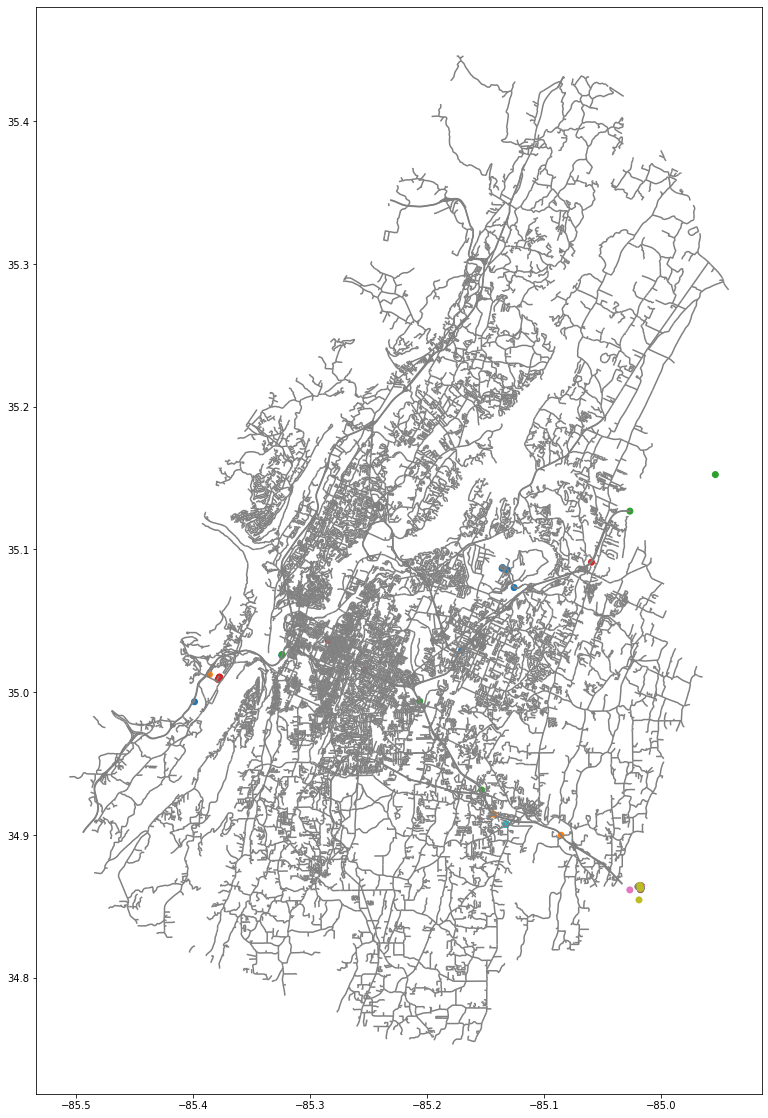

In [288]:
fig, ax = plt.subplots(figsize = (20,20)) 
edges.plot(ax=ax, color="grey")
geo_temp_df.plot(ax=ax, column='VehicleId')

In [12]:
file_dir="/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/fw_data/"
file_nm=file_dir+"gis_datafile1_20210505.csv"
df_gps=pd.read_csv(file_nm)
lon_max=nodes.xcoord.max()
lon_min=nodes.xcoord.min()
lat_max=nodes.ycoord.max()
lat_min=nodes.ycoord.min()
df_gps_CN=df_gps[(df_gps.Lat<=lat_max) & (df_gps.Lat>=lat_min) 
                 & (df_gps.Long<=lon_max) & (df_gps.Long>=lon_min)]
df_gps_CN=df_gps_CN.sort_values(by=['TruckID','OccurredAt'])
df_gps_CN=df_gps_CN.drop_duplicates(subset=['TruckID','Lat','Long','OccurredAt']).reset_index(drop=True)
df_gps_CN=df_gps_CN.rename(columns={'TruckID':'VehicleId','Long':'Lon','OccurredAt':'Timestamp'})
df_gps_CN_clean=pd.DataFrame(columns=['VehicleId','Lat','Lon','Timestamp'])
veh_i_1=0
Lat_i_1=0
Lon_i_1=0
for i in range(0,df_gps_CN.shape[0]):
    if (veh_i_1 != df_gps_CN.VehicleId[i]):
        df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                ,'Lat':df_gps_CN.Lat[i]
                                                ,'Lon':df_gps_CN.Lon[i]
                                                ,'Timestamp':df_gps_CN.Timestamp[i]},ignore_index=True)
        veh_i_1=df_gps_CN.VehicleId[i]
        Lat_i_1=df_gps_CN.Lat[i]
        Lon_i_1=df_gps_CN.Lon[i]
    else:    
        if (round(Lat_i_1,3) != round(df_gps_CN.Lat[i],3)) or (round(Lon_i_1,3) != round(df_gps_CN.Lon[i],3)):
            df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                    ,'Lat':df_gps_CN.Lat[i]
                                                    ,'Lon':df_gps_CN.Lon[i]
                                                    ,'Timestamp':df_gps_CN.Timestamp[i]}, ignore_index=True)
            veh_i_1=df_gps_CN.VehicleId[i]
            Lat_i_1=df_gps_CN.Lat[i]
            Lon_i_1=df_gps_CN.Lon[i]
df_ping_by_veh=df_gps_CN_clean.groupby(['VehicleId']).agg('count').reset_index()
df_ping_by_veh_over5 = df_ping_by_veh[df_ping_by_veh.Lat >5]
temp=df_gps_CN_clean[df_gps_CN_clean.VehicleId.isin(df_ping_by_veh_over5.VehicleId)].reset_index()
temp.to_csv(file_dir+"CN"+"gis_datafile1_20210505.csv")

crs ={'init': 'epsg:4019'}
temp_geometry = [Point(xy) for xy in zip(temp.Lon,temp.Lat)]
geo_temp_df=gpd.GeoDataFrame(temp, crs=crs, geometry=temp_geometry)

fig, ax = plt.subplots(figsize = (20,20)) 
edges.plot(ax=ax, color="grey")
geo_temp_df.plot(ax=ax, column='VehicleId')

NameError: name 'Point' is not defined

In [10]:
file_dir="/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/fw_data/"
file_nm=file_dir+"gis_datafile1_20210324.csv"
df_gps=pd.read_csv(file_nm)
lon_max=nodes.xcoord.max()
lon_min=nodes.xcoord.min()
lat_max=nodes.ycoord.max()
lat_min=nodes.ycoord.min()
df_gps_CN=df_gps[(df_gps.Lat<=lat_max) & (df_gps.Lat>=lat_min) 
                 & (df_gps.Long<=lon_max) & (df_gps.Long>=lon_min)]
df_gps_CN=df_gps_CN.sort_values(by=['TruckID','OccurredAt'])
df_gps_CN=df_gps_CN.drop_duplicates(subset=['TruckID','Lat','Long','OccurredAt']).reset_index(drop=True)
df_gps_CN=df_gps_CN.rename(columns={'TruckID':'VehicleId','Long':'Lon','OccurredAt':'Timestamp'})
df_gps_CN_clean=pd.DataFrame(columns=['VehicleId','Lat','Lon','Timestamp'])
veh_i_1=0
Lat_i_1=0
Lon_i_1=0
for i in range(0,df_gps_CN.shape[0]):
    if (veh_i_1 != df_gps_CN.VehicleId[i]):
        df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                ,'Lat':df_gps_CN.Lat[i]
                                                ,'Lon':df_gps_CN.Lon[i]
                                                ,'Timestamp':df_gps_CN.Timestamp[i]},ignore_index=True)
        veh_i_1=df_gps_CN.VehicleId[i]
        Lat_i_1=df_gps_CN.Lat[i]
        Lon_i_1=df_gps_CN.Lon[i]
    else:    
        if (round(Lat_i_1,3) != round(df_gps_CN.Lat[i],3)) or (round(Lon_i_1,3) != round(df_gps_CN.Lon[i],3)):
            df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                    ,'Lat':df_gps_CN.Lat[i]
                                                    ,'Lon':df_gps_CN.Lon[i]
                                                    ,'Timestamp':df_gps_CN.Timestamp[i]}, ignore_index=True)
            veh_i_1=df_gps_CN.VehicleId[i]
            Lat_i_1=df_gps_CN.Lat[i]
            Lon_i_1=df_gps_CN.Lon[i]
df_ping_by_veh=df_gps_CN_clean.groupby(['VehicleId']).agg('count').reset_index()
df_ping_by_veh_over5 = df_ping_by_veh[df_ping_by_veh.Lat >5]
temp=df_gps_CN_clean[df_gps_CN_clean.VehicleId.isin(df_ping_by_veh_over5.VehicleId)].reset_index()
temp.to_csv(file_dir+"CN"+"gis_datafile1_20210324.csv")


crs ={'init': 'epsg:4019'}
temp_geometry = [Point(xy) for xy in zip(temp.Lon,temp.Lat)]
geo_temp_df=gpd.GeoDataFrame(temp, crs=crs, geometry=temp_geometry)

fig, ax = plt.subplots(figsize = (20,20)) 
edges.plot(ax=ax, color="grey")
geo_temp_df.plot(ax=ax, column='VehicleId')

NameError: name 'Point' is not defined

In [298]:
temp

,index,VehicleId,Lat,Lon,Timestamp,geometry
0,15,824143.0,35.235920,-85.200648,2021-03-24 15:11:24,POINT (-85.20065 35.23592)
1,16,824143.0,35.092226,-85.245202,2021-03-24 16:13:12,POINT (-85.24520 35.09223)
2,17,824143.0,35.092206,-85.245810,2021-03-24 18:13:21,POINT (-85.24581 35.09221)
3,18,824143.0,35.096357,-85.240254,2021-03-24 18:16:03,POINT (-85.24025 35.09636)
4,19,824143.0,35.318365,-85.160752,2021-03-24 18:42:58,POINT (-85.16075 35.31837)
5,20,824143.0,35.342695,-85.190815,2021-03-24 18:46:14,POINT (-85.19082 35.34269)
6,43,937884.0,35.033356,-85.293896,2021-03-24 11:29:03,POINT (-85.29390 35.03336)
7,44,937884.0,35.032748,-85.293224,2021-03-24 11:34:20,POINT (-85.29322 35.03275)
8,45,937884.0,35.032352,-85.292968,2021-03-24 11:40:56,POINT (-85.29297 35.03235)
9,46,937884.0,35.032536,-85.292776,2021-03-24 12:22:18,POINT (-85.29278 35.03254)


In [11]:
file_dir="/Users/kjeong/1_Work/1_3_RMobility/Code/Path_finding/fw_data/"
file_nm=file_dir+"gis_datafile3_20210505.csv"
df_gps=pd.read_csv(file_nm)
lon_max=nodes.xcoord.max()
lon_min=nodes.xcoord.min()
lat_max=nodes.ycoord.max()
lat_min=nodes.ycoord.min()
df_gps_CN=df_gps[(df_gps.Lat<=lat_max) & (df_gps.Lat>=lat_min) 
                 & (df_gps.Lon<=lon_max) & (df_gps.Lon>=lon_min)]
df_gps_CN=df_gps_CN.sort_values(by=['VehicleId','Timestamp'])
df_gps_CN=df_gps_CN.drop_duplicates(subset=['VehicleId','Lat','Lon','Timestamp']).reset_index(drop=True)
df_gps_CN_clean=pd.DataFrame(columns=['VehicleId','Lat','Lon','Timestamp'])
veh_i_1=0
Lat_i_1=0
Lon_i_1=0
for i in range(0,df_gps_CN.shape[0]):
    if (veh_i_1 != df_gps_CN.VehicleId[i]):
        df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                ,'Lat':df_gps_CN.Lat[i]
                                                ,'Lon':df_gps_CN.Lon[i]
                                                ,'Timestamp':df_gps_CN.Timestamp[i]},ignore_index=True)
        veh_i_1=df_gps_CN.VehicleId[i]
        Lat_i_1=df_gps_CN.Lat[i]
        Lon_i_1=df_gps_CN.Lon[i]
    else:    
        if (round(Lat_i_1,3) != round(df_gps_CN.Lat[i],3)) or (round(Lon_i_1,3) != round(df_gps_CN.Lon[i],3)):
            df_gps_CN_clean=df_gps_CN_clean.append({'VehicleId':df_gps_CN.VehicleId[i]
                                                    ,'Lat':df_gps_CN.Lat[i]
                                                    ,'Lon':df_gps_CN.Lon[i]
                                                    ,'Timestamp':df_gps_CN.Timestamp[i]}, ignore_index=True)
            veh_i_1=df_gps_CN.VehicleId[i]
            Lat_i_1=df_gps_CN.Lat[i]
            Lon_i_1=df_gps_CN.Lon[i]
df_ping_by_veh=df_gps_CN_clean.groupby(['VehicleId']).agg('count').reset_index()
df_ping_by_veh_over5 = df_ping_by_veh[df_ping_by_veh.Lat >5]
temp=df_gps_CN_clean[df_gps_CN_clean.VehicleId.isin(df_ping_by_veh_over5.VehicleId)].reset_index()
temp.to_csv(file_dir+"CN"+"gis_datafile3_20210505.csv")

crs ={'init': 'epsg:4019'}
temp_geometry = [Point(xy) for xy in zip(temp.Lon,temp.Lat)]
geo_temp_df=gpd.GeoDataFrame(temp, crs=crs, geometry=temp_geometry)

fig, ax = plt.subplots(figsize = (20,20)) 
edges.plot(ax=ax, color="grey")
geo_temp_df.plot(ax=ax, column='VehicleId')

NameError: name 'Point' is not defined

In [305]:
len(pd.unique(temp['VehicleId']))

9

In [307]:
df_ping_by_veh_over5

,VehicleId,Lat,Lon,Timestamp
132,189235,8,8,8
336,3811409,6,6,6
414,5518326,9,9,9
422,5717820,8,8,8
443,6118016,6,6,6
521,7718432,7,7,7
717,11712688,6,6,6
739,12117184,6,6,6
800,13614099,6,6,6


http://kuanbutts.com/2020/08/25/simplified-map-matching/
    